In [1]:
#import stuff, and set seaborn up
from scipy.stats import norm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import pandas as pd
import time
from scipy.optimize import minimize

# All the functions

In [2]:
#define functions

#create function that finds mena
def mean_pop(a):
    mean = 0
    for i in range(len(a)):
        mean += a[i]*i

    mean = int(mean/sum(a))

    return mean

#creates random distributions
def brownian_population(delta=2, dt=1, n=100, x=0):

    history=np.zeros(n)
    
    # Iterate to compute the steps of the Brownian motion.
    for i in range(n):
        x = x + norm.rvs(scale=delta**2*dt)
        history[i] = x
    
    history = history+np.abs(np.min(history))
    
    original_hist = np.copy(history)
    old_mean = mean_pop(original_hist)
    
    history = np.round(999*history/sum(history))
    
    mean = np.round(np.average(history))
    
    if sum(history) < 999:
        history[0] += 999-sum(history)
        
    elif sum(history) > 999:  
        history[np.argmax(history)] -= -999+sum(history)        
    

    return history, old_mean, original_hist

#create function that finds true positive rates as a function of the cutoff
def true_positive_rate(population, population_that_defaulted, cutoff):
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    number_true_positives = sum(true_positives)
    
    false_negatives = np.logical_and(np.logical_not(population_that_defaulted), 
                                     population_bank_thinks_defaulted)
    
    number_false_negatives = sum(false_negatives) 
    
    true_positive_rate = number_true_positives/(number_true_positives+number_false_negatives)
    
    return true_positive_rate

def difference_bw_positive_rates(pop1, pop2, pop1_that_defaulted, 
                                 pop2_that_defaulted, cutoff1, cutoff2, strictness=0.01):
    true_positive_rate_group1 = true_positive_rate(pop1, pop1_that_defaulted, cutoff1)
    true_positive_rate_group2 = true_positive_rate(pop2, pop2_that_defaulted, cutoff2)
    # for the optimiser's constraints
    return strictness - np.abs(true_positive_rate_group1-true_positive_rate_group2)

def difference_bw_selection_rates(pop1, pop2, pop1_that_defaulted, 
                                  pop2_that_defaulted, cutoff1, cutoff2, strictness=0.01):
    
    _, selection_rate_group1, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    _, selection_rate_group2, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return strictness - np.abs(selection_rate_group1-selection_rate_group2)

#create function that finds bank profit as a function of the cutoff
def bank_profit(population, population_that_defaulted, cutoff, 
                revenue_factor=1, cost_factor=3, credit_upside=1, credit_downside=2):
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    paid_back = sum(true_positives)
    false_positives = np.logical_and(population_that_defaulted, 
                                     np.logical_not(population_bank_thinks_defaulted))
    defaulted = sum(false_positives)
    
    profit = paid_back*revenue_factor - defaulted*cost_factor
    selection_rate = sum(np.logical_not(population_bank_thinks_defaulted))/len(population)
    
    credit_change = (paid_back*credit_upside - defaulted*credit_downside)

    
    return profit, selection_rate, credit_change

def total_bank_profit(pop1, pop2, pop1_that_defaulted, pop2_that_defaulted, cutoff1, cutoff2, 
                      revenue_factor=1, cost_factor=3, credit_upside=1, credit_downside=2):
    
    profit_group1, _, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    profit_group2, _, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return -(profit_group1 + profit_group2)

def create_blues_and_oranges():
    a, mean_a, _ = brownian_population()
    b, mean_b, _ = brownian_population()

    if mean_a >= mean_b:
        blues = np.copy(b)
        oranges = np.copy(a)
    elif mean_a < mean_b:
        blues = np.copy(a)
        oranges = np.copy(b)
    else:
        print("um")

    true_blues = np.zeros(1)
    true_oranges = np.zeros(1)
    
    for i in range(100):
        num_blues = int(blues[i])
        num_oranges = int(oranges[i])
        
        if num_blues >= 0 and num_oranges >= 0:

            elements_blues = np.multiply(np.ones(num_blues),i)
            elements_oranges = np.multiply(np.ones(num_oranges), i)

            true_blues = np.concatenate((true_blues, elements_blues), axis=0)
            true_oranges = np.concatenate((true_oranges, elements_oranges), axis=0)

    #determine who defaulted
    blues_who_defaulted = true_blues.T < np.random.uniform(0, 100, (1000,1)).ravel()
    oranges_who_defaulted = true_oranges.T < np.random.uniform(0, 100, (1000,1)).ravel()

    blues = true_blues.T
    oranges = true_oranges.T
    
    return blues, oranges, blues_who_defaulted, oranges_who_defaulted, mean_a, mean_b
    

## Find a way to create populations

In [3]:
a, mean_a, _ = brownian_population()
b, mean_b, _ = brownian_population()

if mean_a > mean_b:
    blues = np.copy(b)
    oranges = np.copy(a)
else:
    blues = np.copy(a)
    oranges = np.copy(b)
    
true_blues = np.zeros(1)
true_oranges = np.zeros(1)

for i in range(100):
    num_blues = int(blues[i])
    num_oranges = int(oranges[i])
    elements_blues = np.multiply(np.ones(num_blues),i)
    elements_oranges = np.multiply(np.ones(num_oranges), i)
    
    true_blues = np.concatenate((true_blues, elements_blues), axis=0)
    true_oranges = np.concatenate((true_oranges, elements_oranges), axis=0)
    
#determine who defaulted
blues_who_defaulted = true_blues.T < np.random.uniform(0, 100, (1000,1)).ravel()
oranges_who_defaulted = true_oranges.T < np.random.uniform(0, 100, (1000,1)).ravel()

blues = true_blues.T
oranges = true_oranges.T

## Plot populations

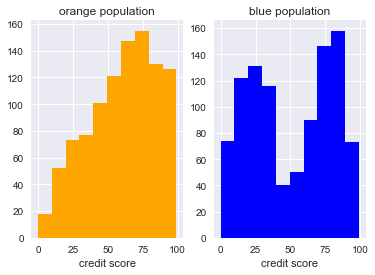

In [4]:
plt.subplot(121)
plt.hist(oranges, bins=10, color="orange")
plt.xlabel("credit score")
plt.title("orange population")
plt.subplot(122)
plt.hist(blues, bins=10, color="b")
plt.xlabel("credit score")
plt.title("blue population")
plt.show()


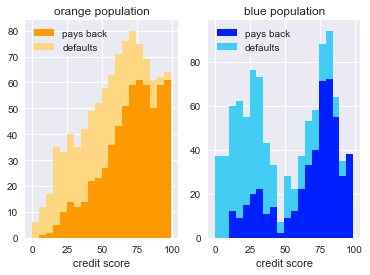

In [5]:
plt.subplot(121)
plt.hist([true_oranges[np.logical_not(oranges_who_defaulted)],true_oranges[oranges_who_defaulted]], 
         stacked=True, bins=20, color=("#ff9900", "#ffd782"))
plt.legend(("pays back", "defaults"))
plt.title("orange population")
plt.xlabel("credit score")
plt.subplot(122)
plt.hist([true_blues[np.logical_not(blues_who_defaulted)],true_blues[blues_who_defaulted]], 
         stacked=True, bins=20, color=("#0021ff", "#41cdf4"))
plt.legend(("pays back", "defaults"))
plt.title("blue population")
plt.xlabel("credit score")
plt.show()

## Optimise for the first time

In [6]:
#what to optimise
to_optimise = lambda x: total_bank_profit(blues, oranges, blues_who_defaulted, 
                                          oranges_who_defaulted, x[0], x[1])

to_constrain = lambda x: difference_bw_positive_rates(blues, oranges, blues_who_defaulted, 
                                                      oranges_who_defaulted, x[0], x[1])

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50
#show initial objective
print("initial guess of", cutoffs, "got us a profit of ", -to_optimise(cutoffs), "$")

initial guess of [50. 50.] got us a profit of  -44 $


### With fairness

In [7]:
#optimise with fairness
a = (0, 100)
bounds = (a, a)
equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
cons = ([equal_true_positives])

solution = minimize(to_optimise, cutoffs, method='SLSQP', constraints = cons,
                    bounds=bounds, options = {'eps': 3})

x_fair = solution.x

In [8]:
print(x_fair)

#final solution got us a profit of:
print("final guess of", x_fair, "got us a profit of ", -to_optimise(x_fair), "$")

_, _, blues_credit_change = bank_profit(blues, blues_who_defaulted, x_fair[0])
_, _, oranges_credit_change = bank_profit(oranges, oranges_who_defaulted, x_fair[1])
#final solution got us a change in credit score of:
print("total credit score change for blues:", blues_credit_change, 
      "|| total credit score change for oranges:", oranges_credit_change)

[66.0333206  63.18205867]
final guess of [66.0333206  63.18205867] got us a profit of  218 $
total credit score change for blues: 163 || total credit score change for oranges: 228


### Without fairness

In [9]:
#optimise without fairness
a = (0, 100)
bounds = (a, a)

solution_unfair = minimize(to_optimise, cutoffs, method='SLSQP',
                    bounds=bounds, options = {'eps': 3})

x_unfair = solution_unfair.x

In [10]:
#final solution got us a profit of:
print("final guess of", x_unfair, "got us a profit of ", -to_optimise(x_unfair), "$")

_, _, blues_credit_change = bank_profit(blues, blues_who_defaulted, x_unfair[0])
_, _, oranges_credit_change = bank_profit(oranges, oranges_who_defaulted, x_unfair[1])
#final solution got us a change in credit score of:
print("total credit score change for blues:", blues_credit_change, 
      "|| total credit score change for oranges:", oranges_credit_change)

final guess of [66.22299436 77.56254375] got us a profit of  240 $
total credit score change for blues: 163 || total credit score change for oranges: 191


# Do this all systematically

## 1. With fairness

In [11]:
num_its = 1000

profit_eq_opt = np.zeros(num_its)
credit_change_blues_eq_opt = np.zeros(num_its)
credit_change_oranges_eq_opt = np.zeros(num_its)

population_log_blues = np.zeros((num_its, 1000))
population_log_oranges = np.zeros((num_its, 1000))

profit_no_fairness = np.zeros(num_its)
credit_change_blues_no_fairness = np.zeros(num_its)
credit_change_oranges_no_fairness = np.zeros(num_its)

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50

#optimise bank profit
to_optimise = lambda x: total_bank_profit(blues, oranges, blues_who_defaulted, 
                                      oranges_who_defaulted, x[0], x[1])

#impose bounds
a = (0, 100)
bounds = (a, a)

how_long_did_it_take = time.time()

for i in range(num_its):
    t = time.time()
    
    
    blues, oranges, blues_who_defaulted, oranges_who_defaulted, _, _ = create_blues_and_oranges()
    
    population_log_blues[i] = blues
    population_log_oranges[i] = oranges
    
    to_constrain = lambda x: difference_bw_positive_rates(blues, oranges, blues_who_defaulted, 
                                                          oranges_who_defaulted, x[0], x[1])
    
    equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
    cons = ([equal_true_positives])

    solution_unfair = minimize(to_optimise, cutoffs, method='SLSQP', 
                        constraints = cons, bounds=bounds, options = {'eps': 3, 'maxiter': 10})

    x_fair = solution_unfair.x
    

    profit_eq_opt[i] = -to_optimise(x_fair)
    _, _, credit_change_blues_eq_opt[i] = bank_profit(blues, blues_who_defaulted, x_fair[0])
    _, _, credit_change_oranges_eq_opt[i] = bank_profit(oranges, oranges_who_defaulted, x_fair[1])
    
    
    solution_fair = minimize(to_optimise, cutoffs, method='SLSQP', 
                        bounds=bounds, options = {'eps': 3})

    x_unfair = solution_fair.x
    
    profit_no_fairness[i] = -to_optimise(x_unfair)
    _, _, credit_change_blues_no_fairness[i] = bank_profit(blues, blues_who_defaulted, x_unfair[0])
    _, _, credit_change_oranges_no_fairness[i] = bank_profit(oranges, oranges_who_defaulted, x_unfair[1])
    
    
    
    if (i % 50 == 0):
        print("iteration", i, "(which took", time.time() - t, "seconds).")

print("This took very long to run", time.time() - how_long_did_it_take, "seconds to be exact.")

iteration 0 (which took 1.4692320823669434 seconds).
iteration 50 (which took 1.499650001525879 seconds).
iteration 100 (which took 2.423582077026367 seconds).
iteration 150 (which took 3.8773202896118164 seconds).
iteration 200 (which took 1.1412789821624756 seconds).
iteration 250 (which took 1.4110488891601562 seconds).
iteration 300 (which took 3.569798231124878 seconds).
iteration 350 (which took 3.7932212352752686 seconds).
iteration 400 (which took 3.821763753890991 seconds).
iteration 450 (which took 1.6137170791625977 seconds).
iteration 500 (which took 1.432121992111206 seconds).
iteration 550 (which took 2.6563150882720947 seconds).
iteration 600 (which took 4.216624736785889 seconds).
iteration 650 (which took 2.5608999729156494 seconds).
iteration 700 (which took 1.1572341918945312 seconds).
iteration 750 (which took 1.2463622093200684 seconds).
iteration 800 (which took 2.494413137435913 seconds).
iteration 850 (which took 3.827677011489868 seconds).
iteration 900 (which 

## Plot distributions of populations under fairness and no fairness constraints

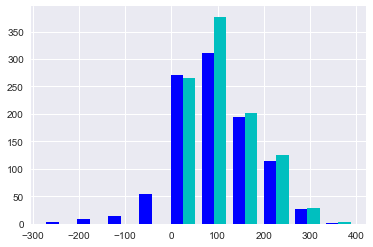

In [12]:
plt.hist((credit_change_blues_eq_opt, credit_change_blues_no_fairness), color=("b", "c"))
plt.show()

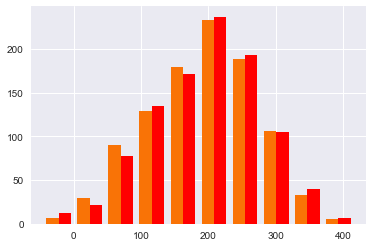

In [13]:
plt.hist((credit_change_oranges_eq_opt, credit_change_oranges_no_fairness), color=("xkcd:orange", "r"))
plt.show()

In [14]:
print("Fairness blues got", sum(credit_change_blues_eq_opt), 
      "whereas unfair blues got", sum(credit_change_blues_no_fairness))

print("Fairness oranges got", sum(credit_change_oranges_eq_opt), 
      "whereas unfair oranges got", sum(credit_change_oranges_no_fairness))

Fairness blues got 94393.0 whereas unfair blues got 111546.0
Fairness oranges got 193129.0 whereas unfair oranges got 196663.0


In [15]:
comparisons_smaller = credit_change_blues_eq_opt < credit_change_blues_no_fairness
comparisons_bigger = credit_change_blues_eq_opt > credit_change_blues_no_fairness
comparisons_equal = np.abs(credit_change_blues_eq_opt - credit_change_blues_no_fairness) < 3

# Generate pretty plots

1. What's the gap between unfair and fair classification
2. What do the distributions look like?
3. How many people default?


### 1. What's the gap between unfair and fair classification

In [16]:
average_blue = np.average(population_log_blues, axis=1)
average_orange = np.average(population_log_oranges, axis=1)
average_distance = average_orange-average_blue
average_distance.shape

(1000,)

In [17]:
frame = np.concatenate((credit_change_blues_eq_opt.reshape(1000,1), 
                        credit_change_oranges_eq_opt.reshape(1000,1), 
                        credit_change_blues_no_fairness.reshape(1000,1), 
                        credit_change_oranges_no_fairness.reshape(1000,1)), axis=1)



change_for_blues = np.concatenate((credit_change_blues_eq_opt.reshape(1000,1), 
                                   credit_change_blues_no_fairness.reshape(1000,1),
                                   average_distance.reshape(1000,1)), axis=1)

credit_changes_blue = pd.DataFrame(change_for_blues)
credit_changes_blue.columns = ["blue with equal opportunity",
                               "blue with no constraints",
                               "average distance"]


credit_changes = pd.DataFrame(frame)
credit_changes.columns = ["blue with equal opportunity", 
                          "orange with equal opportunity", 
                          "blue with no constraint", 
                          "oranges with no constraint"]

In [18]:
credit_changes_blue["distance"] = credit_changes_blue["blue with no constraints"] - credit_changes_blue["blue with equal opportunity"]

credit_changes_blue = credit_changes_blue.sort_values("distance", ascending=False)

credit_changes_blue["sorted index"] = np.arange(1000)
credit_changes_blue.head()

,blue with equal opportunity,blue with no constraints,average distance,distance,sorted index
346,-278.0,59.0,27.697,337.0,0
878,-195.0,85.0,20.873,280.0,1
818,-233.0,12.0,25.756,245.0,2
528,-221.0,15.0,22.617,236.0,3
13,-69.0,162.0,6.951,231.0,4


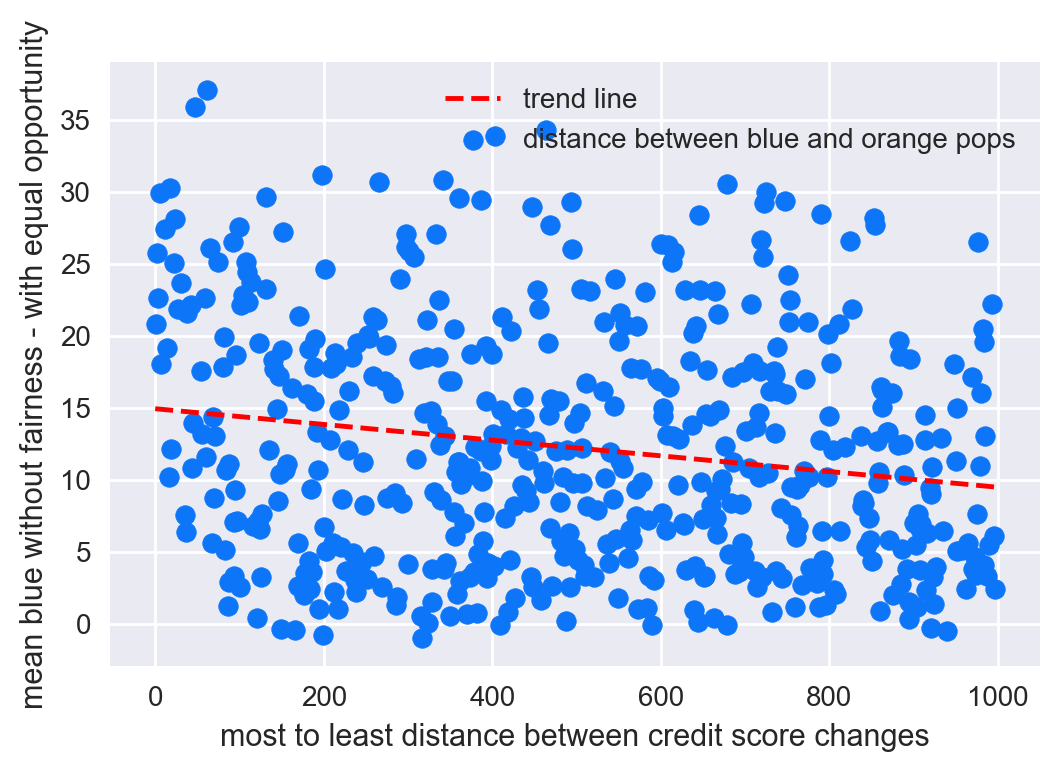

In [88]:
plt.figure(dpi=200)

credit_changes_blue_sub = credit_changes_blue.sample(500)

trendline = np.polyfit(credit_changes_blue_sub["sorted index"], credit_changes_blue_sub["average distance"], 1)
p = np.poly1d(trendline)
plt.plot(credit_changes_blue["sorted index"], p(credit_changes_blue["sorted index"]), "r--")
plt.scatter(credit_changes_blue_sub["sorted index"],credit_changes_blue_sub["average distance"], c='xkcd:deep sky blue')
plt.ylabel("mean blue without fairness - with equal opportunity")
plt.xlabel("most to least distance between credit score changes")
plt.legend(("trend line", "distance between blue and orange pops"), loc=1)
plt.show()

In [20]:
credit_changes_blue.tail()

,blue with equal opportunity,blue with no constraints,average distance,distance,sorted index
443,76.0,0.0,6.067,-76.0,995
950,79.0,0.0,2.424,-79.0,996
953,200.0,120.0,5.710,-80.0,997
334,87.0,1.0,13.745,-86.0,998
923,89.0,0.0,25.004,-89.0,999


In [21]:
print(credit_changes_blue.index[-2])
distance_far = 0
distance_close = 0
distance_medium = 0
for i in range(20):
    index = credit_changes_blue.index[i]
    distance_far += np.average(population_log_oranges[index]) - np.average(population_log_blues[index])

for i in range(20):
    index = credit_changes_blue.index[-i]
    distance_close += np.average(population_log_oranges[index]) - np.average(population_log_blues[index])
    
    
for i in range(20):
    index = credit_changes_blue.index[i+490]
    distance_medium +=np.average(population_log_oranges[index]) - np.average(population_log_blues[index])
print("far=",distance_far/20, "|| close=",distance_close/20, "|| medium=", distance_medium/20)

334
far= 19.098449999999996 || close= 11.9353 || medium= 10.796050000000001


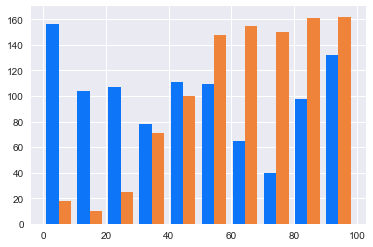

In [22]:
plt.hist((population_log_blues[473], population_log_oranges[473]), color=['xkcd:deep sky blue', 'xkcd:dusty orange'])
plt.show()

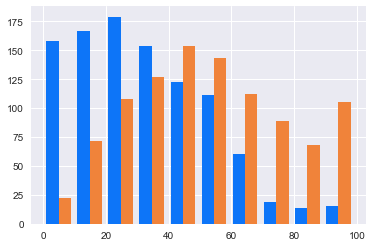

In [23]:
plt.hist((population_log_blues[431], population_log_oranges[431]), color=['xkcd:deep sky blue', 'xkcd:dusty orange'])
plt.show()

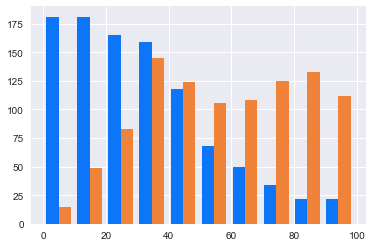

In [24]:
plt.hist((population_log_blues[816], population_log_oranges[816]), color=['xkcd:deep sky blue', 'xkcd:dusty orange'])
plt.show()

In [30]:
print(sum(credit_changes_blue["distance"] > 1))
print(sum(credit_changes_blue["distance"] < -1))

small = credit_changes_blue["distance"] <= 1
butbig = credit_changes_blue["distance"] >= -1
medium = np.logical_and(small, butbig)
print(sum(medium))

601
293
106


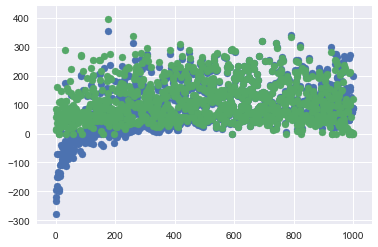

In [25]:
plt.scatter(credit_changes_blue["sorted index"], credit_changes_blue["blue with equal opportunity"])
plt.scatter(credit_changes_blue["sorted index"], credit_changes_blue["blue with no constraints"])
plt.show()

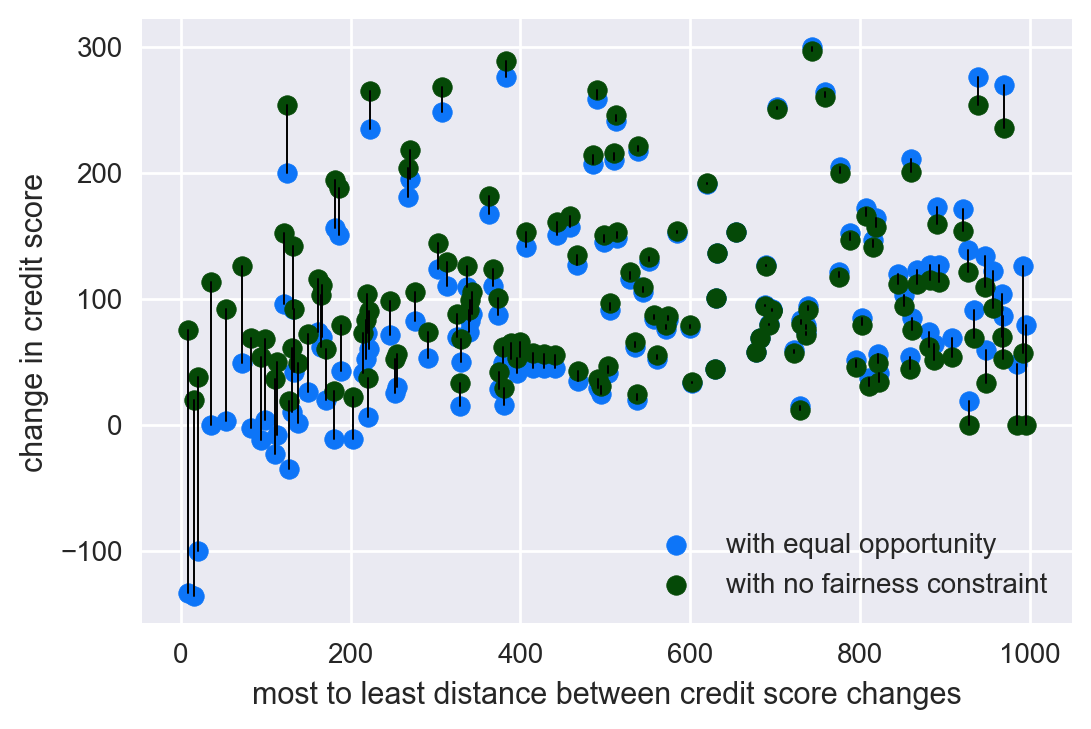

In [72]:
subsampled_credit_changes = credit_changes_blue.sample(150)

average_no_fairness = np.average(subsampled_credit_changes["blue with no constraints"])
average_eq_opt = np.average(subsampled_credit_changes["blue with equal opportunity"])

plt.figure(dpi=200)

plt.scatter(subsampled_credit_changes["sorted index"], 
            subsampled_credit_changes["blue with equal opportunity"], 
            c='xkcd:deep sky blue')
plt.scatter(subsampled_credit_changes["sorted index"], 
            subsampled_credit_changes["blue with no constraints"],
           c='xkcd:darkgreen')

plt.ylabel("change in credit score")
plt.xlabel("most to least distance between credit score changes")
plt.legend(["with equal opportunity", "with no fairness constraint"])

# plt.plot(subsampled_credit_changes["sorted index"], subsampled_credit_changes["blue with equal opportunity"], 'r-')


for i in range(len(subsampled_credit_changes.values)):
    plt.plot(subsampled_credit_changes['sorted index'].values[i]*np.ones((2, 1)),
             [subsampled_credit_changes['blue with equal opportunity'].values[i], 
              subsampled_credit_changes['blue with no constraints'].values[i]], 
             c='black', linewidth=0.7)


plt.savefig("plots/big_sim/distance_between_score_changes.png")
plt.show()

## 2. What do the distributions look like?

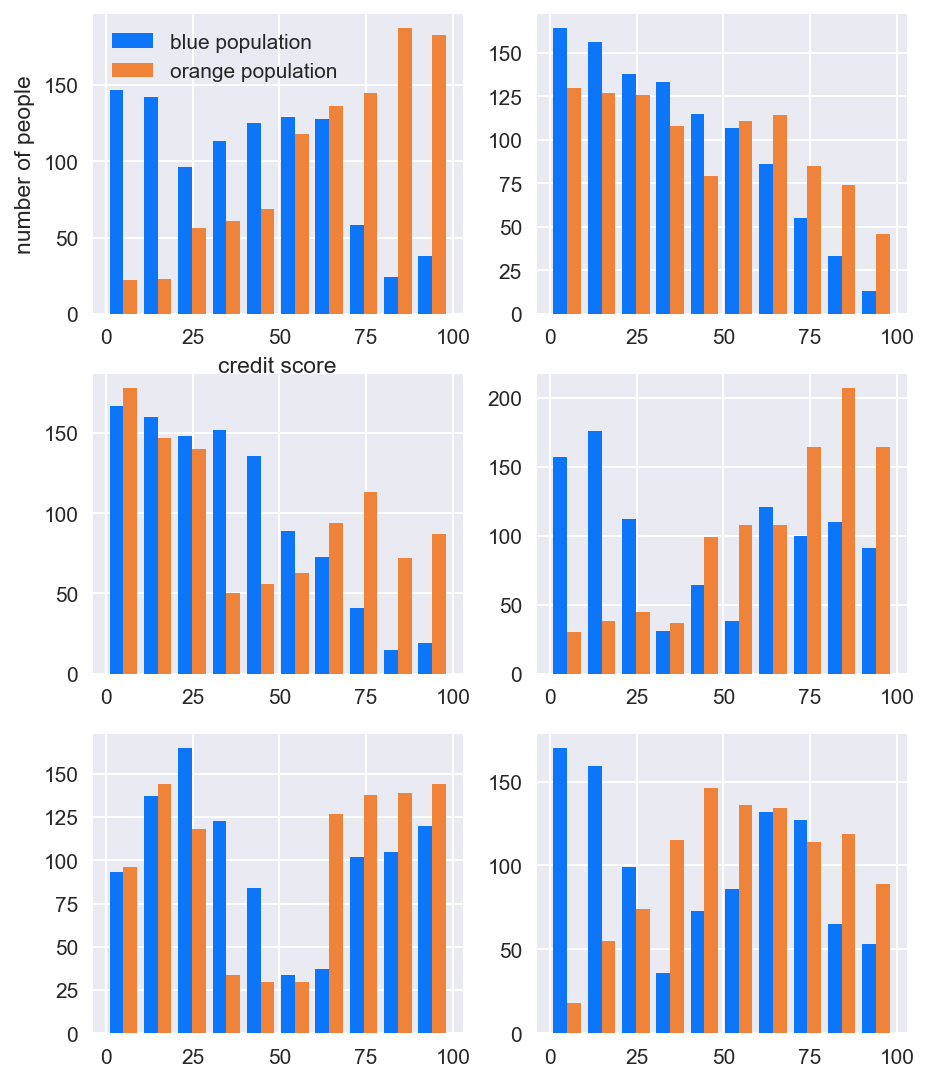

In [27]:
plt.figure(figsize=(7,9), dpi=150)       
sns.set_palette("Paired")
for i in range(6):
    a, b, c, d, mean_a, mean_b = create_blues_and_oranges()
    plt.subplot(3, 2, i+1)

    plt.hist([a, b], color=['xkcd:deep sky blue', 'xkcd:dusty orange'])
    
    if(i==0):
        plt.ylabel("number of people")
        plt.xlabel("credit score")
        plt.legend(("blue population", "orange population"))
        

plt.savefig("plots/big_sim/blues_and_oranges.png")
plt.show()

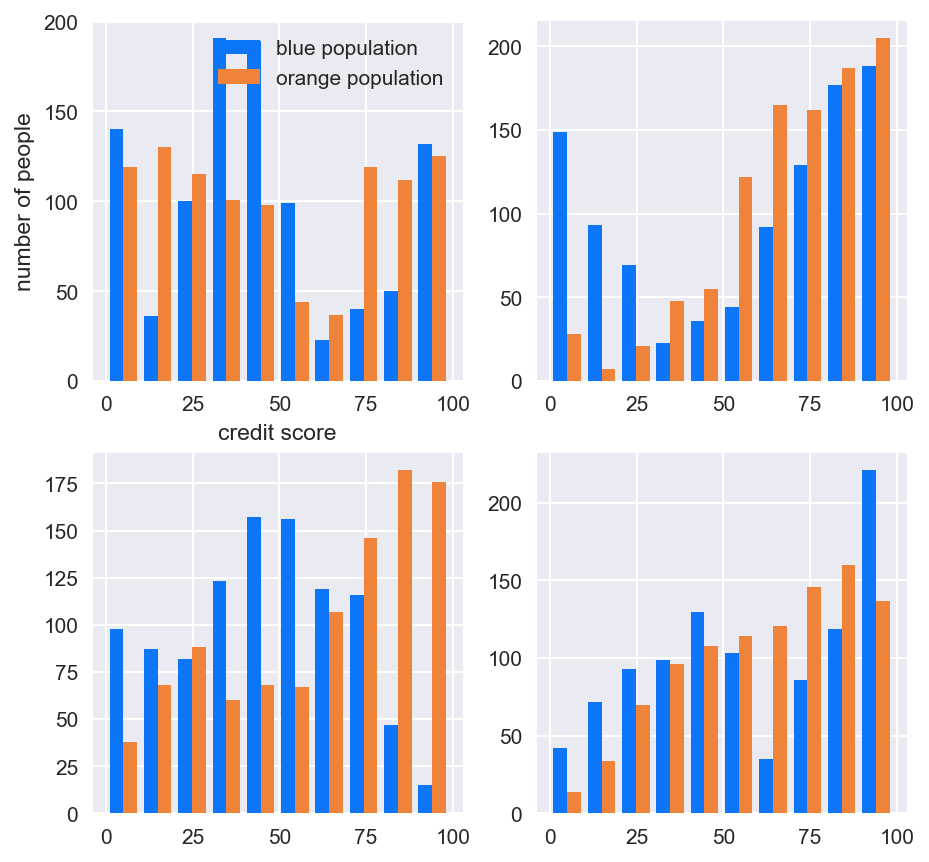

In [28]:
plt.figure(figsize=(7,7), dpi=150)       
sns.set_palette("Paired")
for i in range(4):
    a, b, c, d, mean_a, mean_b = create_blues_and_oranges()
    plt.subplot(2, 2, i+1)

    plt.hist([a, b], color=['xkcd:deep sky blue', 'xkcd:dusty orange'])
    
    if(i==0):
        plt.ylabel("number of people")
        plt.xlabel("credit score")
        plt.legend(("blue population", "orange population"))

plt.savefig("plots/big_sim/blues_and_oranges.png")
plt.show()

### 3. How many people default?

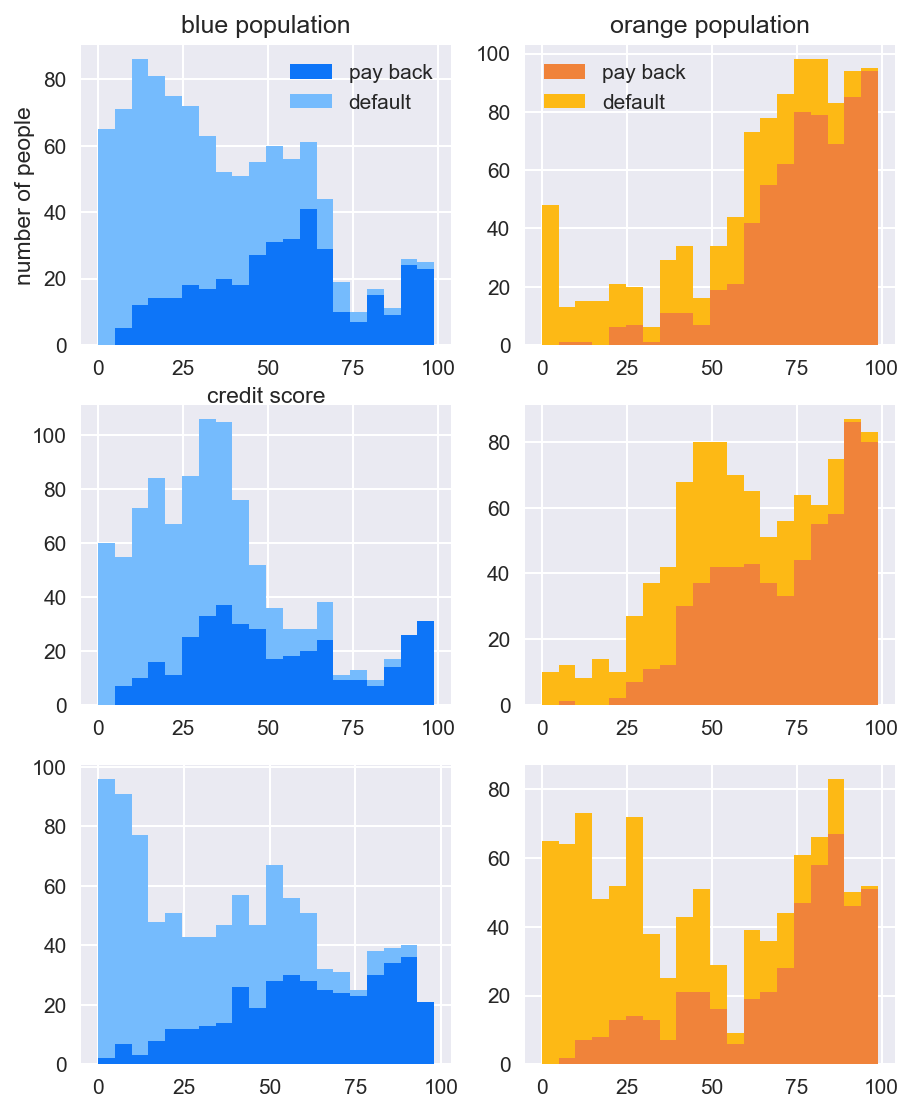

In [29]:
plt.figure(figsize=(7,9), dpi=150)       
sns.set_palette("Paired")
for i in range(6):
    a, b, c, d, _, _ = create_blues_and_oranges()
    plt.subplot(3, 2, i+1)
    
    if(i%2==0):
        plt.hist([a[np.logical_not(c)],a[c]], 
                 stacked=True, bins=20, color=("xkcd:deep sky blue", "xkcd:sky blue"))
    if(i%2==1):
        plt.hist([b[np.logical_not(d)],b[d]], 
                 stacked=True, bins=20, color=("xkcd:dusty orange", "xkcd:orangey yellow"))
    
    if(i==1):

        plt.legend(("pay back", "default"))
        plt.title("orange population")
        
    if(i==0):
        plt.legend(("pay back", "default"))
        plt.title("blue population")
        plt.ylabel("number of people")
        plt.xlabel("credit score")        
    

plt.savefig("plots/big_sim/defaults_no_defaults.png")
plt.show()